<a href="https://colab.research.google.com/github/justHman/Ady/blob/master/Music_Genere_Clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from glob import glob
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
# Định dạng hiển thị số trong NumPy
np.set_printoptions(suppress=True, precision=6)

# Định dạng hiển thị số trong pandas
pd.set_option('display.float_format', '{:.6f}'.format)

In [ ]:
# Cấu hình tham số
num_segment = 10
num_mfcc = 11
sample_rate = 22050
n_fft = 2048
hop_length = 512

In [ ]:
# Khởi tạo dictionary lưu trữ dữ liệu
my_csv = {
    "filename": [],
    "chroma_stft_mean": [], "chroma_stft_var": [],
    "rms_mean": [], "rms_var": [],
    "spectral_centroid_mean": [], "spectral_centroid_var": [],
    "spectral_bandwidth_mean": [], "spectral_bandwidth_var": [],
    "rolloff_mean": [], "rolloff_var": [],
    "zero_crossing_rate_mean": [], "zero_crossing_rate_var": [],
    "harmony_mean": [], "harmony_var": [],
    "perceptr_mean": [], "perceptr_var": [], "tempo": []
}

# Thêm các đặc trưng MFCC vào dictionary
for number in range(1, num_mfcc + 1):
    my_csv[f"mfcc{number}_mean"] = []
    my_csv[f"mfcc{number}_var"] = []

# Thêm cột nhãn
my_csv["label"] = []

In [ ]:
print(my_csv)

{'filename': [], 'chroma_stft_mean': [], 'chroma_stft_var': [], 'rms_mean': [], 'rms_var': [], 'spectral_centroid_mean': [], 'spectral_centroid_var': [], 'spectral_bandwidth_mean': [], 'spectral_bandwidth_var': [], 'rolloff_mean': [], 'rolloff_var': [], 'zero_crossing_rate_mean': [], 'zero_crossing_rate_var': [], 'harmony_mean': [], 'harmony_var': [], 'perceptr_mean': [], 'perceptr_var': [], 'tempo': [], 'mfcc1_mean': [], 'mfcc1_var': [], 'mfcc2_mean': [], 'mfcc2_var': [], 'mfcc3_mean': [], 'mfcc3_var': [], 'mfcc4_mean': [], 'mfcc4_var': [], 'mfcc5_mean': [], 'mfcc5_var': [], 'mfcc6_mean': [], 'mfcc6_var': [], 'mfcc7_mean': [], 'mfcc7_var': [], 'mfcc8_mean': [], 'mfcc8_var': [], 'mfcc9_mean': [], 'mfcc9_var': [], 'mfcc10_mean': [], 'mfcc10_var': [], 'mfcc11_mean': [], 'mfcc11_var': [], 'label': []}


In [ ]:
dataset_path = "/content/drive/MyDrive/Dataset/Music_genere/genres_original"
audio_files = glob(dataset_path + "/*/*")

In [ ]:
print(len(audio_files))
a = audio_files[0].split('/')[-2]
print(audio_files[0])
print(a)

1000
/content/drive/MyDrive/Dataset/Music_genere/genres_original/rock/rock.00009.wav
rock


In [ ]:
samples_per_segment = int(sample_rate * 30 / num_segment) # 661500 / 10 = 66150
genre = ""

for f in sorted(audio_files):
  # f có dạng: /content/drive/MyDrive/Dataset/Music_genere/genres_original/rock/rock.00009.wav
  if genre != f.split('/')[-2]: # Lấy tên thể loại (rock)
    genre = f.split('/')[-2]
    print("Processing " + genre + "...")

  fname = f.split('/')[-1] # Lấy tên file (rock.00009.wav)
  print(fname)

  try: # Load .wave thông qua librosa
    y, sr = librosa.load(f, sr=sample_rate)
  except Exception as e:
    print(f"Lỗi khi xử lý file {fname}: {e}")
    continue

  for n in range(num_segment):
    my_csv["label"].append(genre)
    y_seg = y[samples_per_segment * n: samples_per_segment * (n + 1)] # Khoảng 1: 0 - 66150 | Khoảng 2: 66150 - 2 * 661150

    # Chroma feature
    chromagram = librosa.feature.chroma_stft(y=y_seg, sr=sample_rate, hop_length=hop_length)
    my_csv["chroma_stft_mean"].append(chromagram.mean())
    my_csv["chroma_stft_var"].append(chromagram.var())

    # Root Mean Square Energy
    RMSEn = librosa.feature.rms(y=y_seg)
    my_csv["rms_mean"].append(RMSEn.mean())
    my_csv["rms_var"].append(RMSEn.var())

    # Spectral Centroid
    spec_cent = librosa.feature.spectral_centroid(y=y_seg)
    my_csv["spectral_centroid_mean"].append(spec_cent.mean())
    my_csv["spectral_centroid_var"].append(spec_cent.var())

    # Spectral Bandwidth
    spec_band = librosa.feature.spectral_bandwidth(y=y_seg, sr=sample_rate)
    my_csv["spectral_bandwidth_mean"].append(spec_band.mean())
    my_csv["spectral_bandwidth_var"].append(spec_band.var())

    # Rolloff
    spec_roll = librosa.feature.spectral_rolloff(y=y_seg, sr=sample_rate)
    my_csv["rolloff_mean"].append(spec_roll.mean())
    my_csv["rolloff_var"].append(spec_roll.var())

    # Zero Crossing Rate
    zero_crossing = librosa.feature.zero_crossing_rate(y=y_seg)
    my_csv["zero_crossing_rate_mean"].append(zero_crossing.mean())
    my_csv["zero_crossing_rate_var"].append(zero_crossing.var())

    # Harmonics and Percussive
    harmony, perceptr = librosa.effects.hpss(y=y_seg)
    my_csv["harmony_mean"].append(harmony.mean())
    my_csv["harmony_var"].append(harmony.var())
    my_csv["perceptr_mean"].append(perceptr.mean())
    my_csv["perceptr_var"].append(perceptr.var())

    # Tempo
    tempo, _ = librosa.beat.beat_track(y=y_seg, sr=sample_rate)
    my_csv["tempo"].append(tempo)

    # MFCC
    mfcc = librosa.feature.mfcc(y=y_seg, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    fseg_name = '.'.join(fname.split('.')[:2]) + f'.{n + 1}.wav' # rock.00009.wav -> rock.00009.0(n).wav
    my_csv["filename"].append(fseg_name)

    for number in range(11):
        my_csv[f"mfcc{number + 1}_mean"].append(mfcc[number].mean())
        my_csv[f"mfcc{number + 1}_var"].append(mfcc[number].var())

Processing blues...
blues.00000.wav
blues.00001.wav
blues.00002.wav
blues.00003.wav
blues.00004.wav
blues.00005.wav
blues.00006.wav
blues.00007.wav
blues.00008.wav
blues.00009.wav
blues.00010.wav
blues.00011.wav
blues.00012.wav
blues.00013.wav
blues.00014.wav
blues.00015.wav
blues.00016.wav
blues.00017.wav
blues.00018.wav
blues.00019.wav
blues.00020.wav
blues.00021.wav
blues.00022.wav
blues.00023.wav
blues.00024.wav
blues.00025.wav
blues.00026.wav
blues.00027.wav
blues.00028.wav
blues.00029.wav
blues.00030.wav
blues.00031.wav
blues.00032.wav
blues.00033.wav
blues.00034.wav
blues.00035.wav
blues.00036.wav
blues.00037.wav
blues.00038.wav
blues.00039.wav
blues.00040.wav
blues.00041.wav
blues.00042.wav
blues.00043.wav
blues.00044.wav
blues.00045.wav
blues.00046.wav
blues.00047.wav
blues.00048.wav
blues.00049.wav
blues.00050.wav
blues.00051.wav
blues.00052.wav
blues.00053.wav
blues.00054.wav
blues.00055.wav
blues.00056.wav
blues.00057.wav
blues.00058.wav
blues.00059.wav
blues.00060.wav
blue

<ipython-input-7-f0cb869a190f>:14: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(f, sr=sample_rate)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Lỗi khi xử lý file jazz.00054.wav: 
jazz.00055.wav
jazz.00056.wav
jazz.00057.wav
jazz.00058.wav
jazz.00059.wav
jazz.00060.wav
jazz.00061.wav
jazz.00062.wav
jazz.00063.wav
jazz.00064.wav
jazz.00065.wav
jazz.00066.wav
jazz.00067.wav
jazz.00068.wav
jazz.00069.wav
jazz.00070.wav
jazz.00071.wav
jazz.00072.wav
jazz.00073.wav
jazz.00074.wav
jazz.00075.wav
jazz.00076.wav
jazz.00077.wav
jazz.00078.wav
jazz.00079.wav
jazz.00080.wav
jazz.00081.wav
jazz.00082.wav
jazz.00083.wav
jazz.00084.wav
jazz.00085.wav
jazz.00086.wav
jazz.00087.wav
jazz.00088.wav
jazz.00089.wav
jazz.00090.wav
jazz.00091.wav
jazz.00092.wav
jazz.00093.wav
jazz.00094.wav
jazz.00095.wav
jazz.00096.wav
jazz.00097.wav
jazz.00098.wav
jazz.00099.wav
Processing metal...
metal.00000.wav
metal.00001.wav
metal.00002.wav
metal.00003.wav
metal.00004.wav
metal.00005.wav
metal.00006.wav
metal.00007.wav
metal.00008.wav
metal.00009.wav
metal.00010.wav
metal.00011.wav
metal.00012.wav
metal.00013.wav
metal.00014.wav
metal.00015.wav
metal.00016.w

In [ ]:
dataset_path = "/classic_125.wav"
print(dataset_path)

y_seg, sr = librosa.load(dataset_path, sr=sample_rate)

/classic_125.wav


In [ ]:
del my_csv["filename"]
del my_csv["label"]

KeyError: 'filename'

In [ ]:
# Chroma feature
chromagram = librosa.feature.chroma_stft(y=y_seg, sr=sample_rate, hop_length=hop_length)
my_csv["chroma_stft_mean"].append(chromagram.mean())
my_csv["chroma_stft_var"].append(chromagram.var())

# Root Mean Square Energy
RMSEn = librosa.feature.rms(y=y_seg)
my_csv["rms_mean"].append(RMSEn.mean())
my_csv["rms_var"].append(RMSEn.var())

# Spectral Centroid
spec_cent = librosa.feature.spectral_centroid(y=y_seg)
my_csv["spectral_centroid_mean"].append(spec_cent.mean())
my_csv["spectral_centroid_var"].append(spec_cent.var())

# Spectral Bandwidth
spec_band = librosa.feature.spectral_bandwidth(y=y_seg, sr=sample_rate)
my_csv["spectral_bandwidth_mean"].append(spec_band.mean())
my_csv["spectral_bandwidth_var"].append(spec_band.var())

# Rolloff
spec_roll = librosa.feature.spectral_rolloff(y=y_seg, sr=sample_rate)
my_csv["rolloff_mean"].append(spec_roll.mean())
my_csv["rolloff_var"].append(spec_roll.var())

# Zero Crossing Rate
zero_crossing = librosa.feature.zero_crossing_rate(y=y_seg)
my_csv["zero_crossing_rate_mean"].append(zero_crossing.mean())
my_csv["zero_crossing_rate_var"].append(zero_crossing.var())

# Harmonics and Percussive
harmony, perceptr = librosa.effects.hpss(y=y_seg)
my_csv["harmony_mean"].append(harmony.mean())
my_csv["harmony_var"].append(harmony.var())
my_csv["perceptr_mean"].append(perceptr.mean())
my_csv["perceptr_var"].append(perceptr.var())

# Tempo
tempo, _ = librosa.beat.beat_track(y=y_seg, sr=sample_rate)
my_csv["tempo"].append(tempo[0])

# MFCC
mfcc = librosa.feature.mfcc(y=y_seg, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
for number in range(11):
  my_csv[f"mfcc{number + 1}_mean"].append(mfcc[number].mean())
  my_csv[f"mfcc{number + 1}_var"].append(mfcc[number].var())

In [ ]:
print(my_csv)

{'chroma_stft_mean': [0.25047356, 0.3503112, 0.36150983, 0.35570076, 0.28686872, 0.30251086], 'chroma_stft_var': [0.08738629, 0.11219772, 0.0882458, 0.09077068, 0.08471677, 0.08422771], 'rms_mean': [0.09193406, 0.20796454, 0.22857161, 0.2830523, 0.040027976, 0.07449515], 'rms_var': [0.0015225954, 0.008455039, 0.009776651, 0.00982235, 0.00084538513, 0.0030318454], 'spectral_centroid_mean': [1649.212046063648, 1240.2865560206262, 2055.5292626024966, 2154.8387625355736, 1239.037089849241, 1486.6548380081808], 'spectral_centroid_var': [259476.5049510751, 775162.292625183, 955600.0940957753, 611136.6331896527, 120467.14422079088, 246358.58369524434], 'spectral_bandwidth_mean': [1923.972167209098, 1720.1620992306707, 2285.103647044942, 2459.228535159634, 1358.3301412464873, 1570.9222415361965], 'spectral_bandwidth_var': [142916.2069959668, 498860.0495391158, 365038.7220751421, 222473.60529680396, 114512.24237571834, 237867.50509684283], 'rolloff_mean': [3269.1312736771056, 2608.789371732865,

In [ ]:
df = pd.DataFrame(my_csv)
df

chroma_stft_mean  chroma_stft_var  rms_mean  rms_var  \
0          0.250474         0.087386  0.091934 0.001523   
1          0.350311         0.112198  0.207965 0.008455   
2          0.361510         0.088246  0.228572 0.009777   
3          0.355701         0.090771  0.283052 0.009822   
4          0.286869         0.084717  0.040028 0.000845   
5          0.302511         0.084228  0.074495 0.003032   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1649.212046          259476.504951              1923.972167   
1             1240.286556          775162.292625              1720.162099   
2             2055.529263          955600.094096              2285.103647   
3             2154.838763          611136.633190              2459.228535   
4             1239.037090          120467.144221              1358.330141   
5             1486.654838          246358.583695              1570.922242   

   spectral_bandwidth_var  rolloff_mean    rolloff_var  ...  mfcc7_mean  \
0           142916.206996   3269.131274 1046148.907011  ...   -2.308693   
1           498860.049539   2608.789372 4551815.700295  ...    9.378836   
2           365038.722075   4285.254699 3693251.466055  ...   -2.859642   
3           222473.605297   4651.077551 2866251.654281  ...    9.712320   
4           114512.242376   2337.040959  509899.897550  ...   -8.795781   
5           237867.505097   2774.913536 1155313.869679  ...   -8.563066   

   mfcc7_var  mfcc8_mean  mfcc8_var  mfcc9_mean  mfcc9_var  mfcc10_mean  \
0  99.497871    4.867599 116.415611   -1.129270 125.162941     3.732864   
1 254.813461   13.488512 182.666077    8.394042 174.386246    16.671930   
2 182.180862   -3.052345 186.298401    3.402339 187.416382     0.403390   
3  90.136589   10.731456  93.630531   -1.584924  79.241837     8.199548   
4  94.026253   -4.372903  97.304451   -5.913225  88.464989    -2.474602   
5  63.325150   -6.747416  88.599899  -11.644957  85.284439     0.868586   

   mfcc10_var  mfcc11_mean  mfcc11_var  
0  118.194778   -10.602319  123.651245  
1  157.633041    -2.189758  116.885208  
2  149.469101    -5.518354  103.078003  
3   98.449387    -1.148478   63.921253  
4  111.107086    -4.931719  115.881653  
5   98.638931    -3.701438   72.458977  

[6 rows x 39 columns]

In [ ]:
print(my_csv)
for i in my_csv:
  print(i)

{'filename': ['blues.00000.1.wav', 'blues.00000.2.wav', 'blues.00000.3.wav', 'blues.00000.4.wav', 'blues.00000.5.wav', 'blues.00000.6.wav', 'blues.00000.7.wav', 'blues.00000.8.wav', 'blues.00000.9.wav', 'blues.00000.10.wav', 'blues.00001.1.wav', 'blues.00001.2.wav', 'blues.00001.3.wav', 'blues.00001.4.wav', 'blues.00001.5.wav', 'blues.00001.6.wav', 'blues.00001.7.wav', 'blues.00001.8.wav', 'blues.00001.9.wav', 'blues.00001.10.wav', 'blues.00002.1.wav', 'blues.00002.2.wav', 'blues.00002.3.wav', 'blues.00002.4.wav', 'blues.00002.5.wav', 'blues.00002.6.wav', 'blues.00002.7.wav', 'blues.00002.8.wav', 'blues.00002.9.wav', 'blues.00002.10.wav', 'blues.00003.1.wav', 'blues.00003.2.wav', 'blues.00003.3.wav', 'blues.00003.4.wav', 'blues.00003.5.wav', 'blues.00003.6.wav', 'blues.00003.7.wav', 'blues.00003.8.wav', 'blues.00003.9.wav', 'blues.00003.10.wav', 'blues.00004.1.wav', 'blues.00004.2.wav', 'blues.00004.3.wav', 'blues.00004.4.wav', 'blues.00004.5.wav', 'blues.00004.6.wav', 'blues.00004.7.w

In [ ]:
df = pd.DataFrame(my_csv)
df.to_csv('/content/drive/MyDrive/Dataset/Music_genere/features_3s.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/Music_genere/features_3s.csv')
df['tempo'] = df['tempo'].str.replace(r'[\[\]]', '', regex=True)

x = df.drop(['filename', 'label'], axis=1)
y = df['label']

y = LabelEncoder().fit_transform(y)
label_encoder = {0: 'blues', 1: 'classical', 2: 'country',
                 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal',
                 7: 'pop', 8: 'reggae', 9: 'rock'
}

In [ ]:
df.describe()

chroma_stft_mean  chroma_stft_var    rms_mean     rms_var  \
count       9990.000000      9990.000000 9990.000000 9990.000000   
mean           0.379990         0.084878    0.130072    0.002672   
std            0.090608         0.009674    0.068164    0.003560   
min            0.108073         0.015217    0.000947    0.000000   
25%            0.316090         0.079807    0.083282    0.000629   
50%            0.385192         0.085116    0.120503    0.001501   
75%            0.442904         0.091145    0.175398    0.003114   
max            0.751176         0.120717    0.440458    0.032380   

       spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
count             9990.000000            9990.000000              9990.000000   
mean              2202.369980          415938.708105              2244.896920   
std                750.391602          433912.382402               541.333433   
min                479.905803            2161.497566               499.577102   
25%               1634.440203          122867.967225              1890.759726   
50%               2213.635011          264615.418750              2233.838250   
75%               2714.394794          561149.544225              2591.195841   
max               5432.278843         4801846.675000              3708.279663   

       spectral_bandwidth_var  rolloff_mean     rolloff_var  ...  mfcc7_mean  \
count             9990.000000   9990.000000     9990.000000  ... 9990.000000   
mean            118306.281224   4572.536972  1623622.159595  ...   -5.783460   
std             100221.698141   1639.176635  1482199.942718  ...   11.055621   
min               1295.350394    673.906438     1130.834489  ...  -45.168076   
25%              49432.129125   3390.961867   556971.606975  ...  -14.380173   
50%              90345.317280   4636.264273  1156686.326000  ...   -5.967654   
75%             157889.796275   5597.970252  2251552.072500  ...    2.705157   
max            1237130.808000   9486.121357 12936614.200000  ...   27.391320   

        mfcc7_var  mfcc8_mean   mfcc8_var  mfcc9_mean   mfcc9_var  \
count 9990.000000 9990.000000 9990.000000 9990.000000 9990.000000   
mean    98.694290   10.718563   74.902430   -7.539674   74.426332   
std     65.311078   11.093195   45.634855    9.338701   44.587264   
min      7.892602  -40.252440    7.065603  -39.354927    8.261392   
25%     51.890999    2.534938   42.633654  -14.522641   43.227019   
50%     81.599295   10.624049   63.644871   -7.955903   62.646157   
75%    127.067185   19.506405   94.324635   -0.422545   93.651413   
max    662.918300   65.610520  544.756840   32.111057  409.404450   

       mfcc10_mean  mfcc10_var  mfcc11_mean  mfcc11_var  
count  9990.000000 9990.000000  9990.000000 9990.000000  
mean      8.240264   68.849936    -6.479726   63.837602  
std       8.821364   41.687713     7.800288   40.049541  
min     -32.836132    7.175274   -40.048430    4.854333  
25%       1.700928   40.296704   -12.180371   37.729818  
50%       8.095945   59.229832    -6.290264   53.913069  
75%      15.253396   85.810653    -0.801575   79.326277  
max      58.371730  486.100500    46.677635  697.528800  

[8 rows x 38 columns]

In [ ]:
df.shape

(9990, 41)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)
scaler = StandardScaler() # Create a single StandardScaler instance
x_train = scaler.fit_transform(x_train) # Fit and transform the training data
x_test = scaler.transform(x_test) # Transform the test data using the same scaler

In [ ]:
print(x_test[:1])

[[ 0.23206527 -1.92568623 -0.36667153 -0.58427436 -1.46036311 -0.69628407
  -1.01439319  0.17750684 -1.28505253 -0.30811797 -1.42835355 -0.65695396
   0.24932565 -0.28084     0.86739301 -0.7186295  -1.34088395 -0.48059559
  -0.54491817  1.19603838 -0.4895928   0.42280218 -0.81361054  0.78205174
  -1.02659678 -0.08040257 -0.60262716  0.93607219 -0.98190164 -0.6829769
  -0.89342195  0.50495124  0.08904451  0.24571551 -0.2165023   0.46877948
  -0.71992743 -0.54603182 -0.35206328]]


In [ ]:
svm_cls = SVC(kernel='rbf', C=10, gamma=0.1, probability=True)
svm_cls.fit(x_train, y_train)

train_score = svm_cls.score(x_train, y_train)
test_score = svm_cls.score(x_test, y_test)

[2 4 1 7 1 8 1 3 3 9 6 9 2 5 4 4 2 1 9 3 8 5 3 5 0 7 7 9 4 8 8 7 0 4 3 0 6
 5 3 3 5 7 7 9 8 1 2 5 5 1]
Thể loại của x_test đầu tiên là: rock
Training set score: 0.999
Test set score: 0.909
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       200
           1       0.98      0.95      0.96       211
           2       0.88      0.86      0.87       190
           3       0.97      0.90      0.93       189
           4       0.78      0.93      0.85       194
           5       0.92      0.92      0.92       212
           6       0.97      0.95      0.96       206
           7       0.90      0.94      0.92       202
           8       0.92      0.93      0.93       195
           9       0.91      0.80      0.85       199

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998



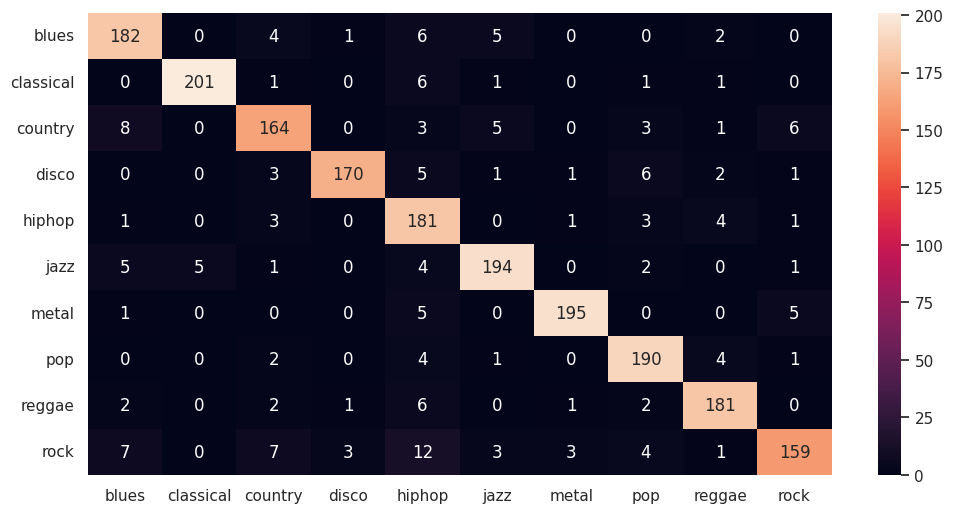

In [ ]:
y_pred = svm_cls.predict(x_test)
print(y_pred[:50])
print('Thể loại của x_test đầu tiên là:', label_encoder[y_pred[9]])

print("Training set score: {:.3f}".format(train_score))
print("Test set score: {:.3f}".format(test_score))

encoder_x = [label_encoder[i] for i in range(10)]
encoder_y = [label_encoder[i] for i in range(10)]

cf_matrix3 = confusion_matrix(y_test, y_pred)
sns.set(rc={'figure.figsize':(12,6)})
sns.heatmap(cf_matrix3, annot=True, fmt='d', xticklabels=encoder_x, yticklabels=encoder_y)
print(classification_report(y_test, y_pred))

[2 9 1 7 1 8 1 3 3 2 6 9 2 5 4 4 4 1 9 3 8 5 3 5 0 7 7 9 9 8 8 7 0 4 3 0 6
 5 3 3 9 7 7 9 8 1 4 5 5 1]
classical


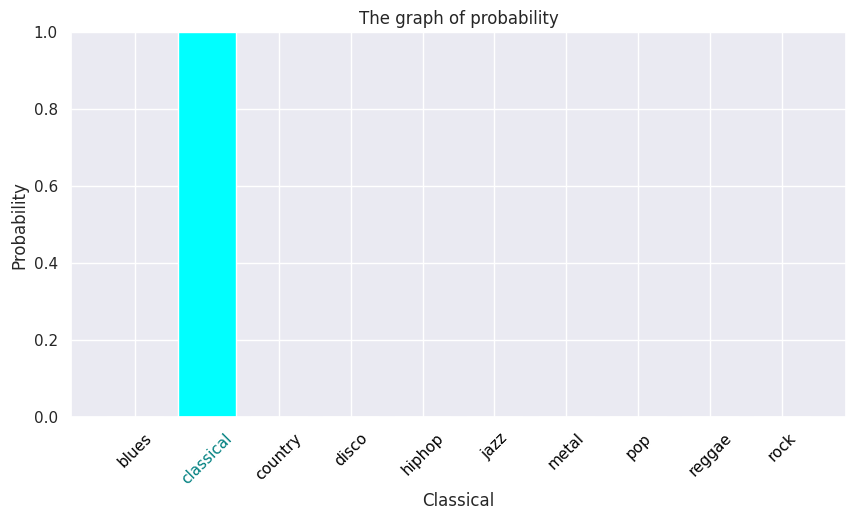

In [ ]:
y_prob = svm_cls.predict_proba(x_test)
i =2
test = y_prob[i]
category = label_encoder[y_test[i]]
print(y_test[:50])
print(category)

# Xác định vị trí giá trị lớn nhất
max_index = np.argmax(test)

# Tạo danh sách màu: giá trị lớn nhất là 'red', còn lại là 'skyblue'
colors = ['brown'] * len(test)
colors[max_index] = 'cyan'  # Làm nổi bật giá trị lớn nhất

# Vẽ biểu đồ với màu sắc tùy chỉnh
plt.figure(figsize=(10, 5))
plt.bar(label_encoder.values(), test, color=colors)

# Định dạng biểu đồ
plt.xlabel(category.capitalize())
plt.ylabel("Probability")
plt.title("The graph of probability")
plt.ylim(0, 1)  # Xác suất nằm trong khoảng [0,1]

# Gán nhãn cho trục x bằng tên thể loại nhạc
# Use a range of numbers for ticks and label_encoder.values() for labels
# colors1 = ['black'] * len(test) # Removed this line as it's no longer needed
# colors1[y_test[i]] = 'green'  # Làm nổi bật giá trị lớn nhất # Removed this line as well

# Get the current x-axis ticks and labels
ticks = plt.xticks()[0]
labels = plt.xticks()[1]

# Loop through the ticks and labels, setting the color individually
for tick, label, color_val in zip(ticks, labels, ['black'] * len(test)):  # Initialize color_val here
    if label.get_text() == label_encoder[y_test[i]]:  # Check if label matches the desired category
        color_val = 'Teal'
    label.set_color(color_val)

plt.xticks(ticks, labels, rotation=45)  # Set the ticks and labels with updated colors

# Hiển thị biểu đồ
plt.show()

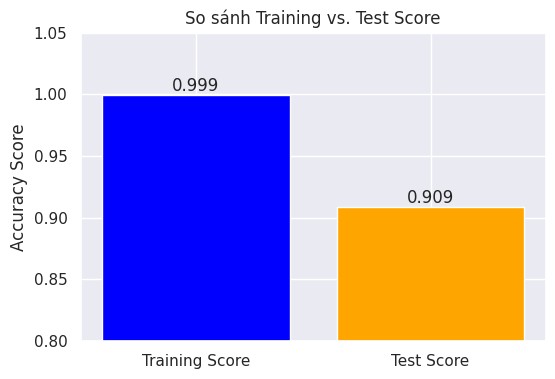

In [ ]:
scores = [train_score, test_score]
labels = ['Training Score', 'Test Score']

# Vẽ biểu đồ cột
plt.figure(figsize=(6, 4))
plt.bar(labels, scores, color=['blue', 'orange'])

# Gắn nhãn giá trị
plt.ylabel('Accuracy Score')
plt.title('So sánh Training vs. Test Score')
plt.ylim(0.8, 1.05)  # Giới hạn trục Y để dễ nhìn thấy sự chênh lệch
plt.text(0, train_score, f"{train_score:.3f}", ha='center', va='bottom', fontsize=12)
plt.text(1, test_score, f"{test_score:.3f}", ha='center', va='bottom', fontsize=12)

# Hiển thị biểu đồ
plt.show()

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, cv=5, verbose=1)
grid.fit(x_train, y_train)

print("Best parameters:", grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [ ]:
df

chroma_stft_mean  chroma_stft_var  rms_mean  rms_var  \
0          0.250474         0.087386  0.091934 0.001523   
1          0.350311         0.112198  0.207965 0.008455   
2          0.361510         0.088246  0.228572 0.009777   
3          0.355701         0.090771  0.283052 0.009822   
4          0.286869         0.084717  0.040028 0.000845   
5          0.302511         0.084228  0.074495 0.003032   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1649.212046          259476.504951              1923.972167   
1             1240.286556          775162.292625              1720.162099   
2             2055.529263          955600.094096              2285.103647   
3             2154.838763          611136.633190              2459.228535   
4             1239.037090          120467.144221              1358.330141   
5             1486.654838          246358.583695              1570.922242   

   spectral_bandwidth_var  rolloff_mean    rolloff_var  ...  mfcc7_mean  \
0           142916.206996   3269.131274 1046148.907011  ...   -2.308693   
1           498860.049539   2608.789372 4551815.700295  ...    9.378836   
2           365038.722075   4285.254699 3693251.466055  ...   -2.859642   
3           222473.605297   4651.077551 2866251.654281  ...    9.712320   
4           114512.242376   2337.040959  509899.897550  ...   -8.795781   
5           237867.505097   2774.913536 1155313.869679  ...   -8.563066   

   mfcc7_var  mfcc8_mean  mfcc8_var  mfcc9_mean  mfcc9_var  mfcc10_mean  \
0  99.497871    4.867599 116.415611   -1.129270 125.162941     3.732864   
1 254.813461   13.488512 182.666077    8.394042 174.386246    16.671930   
2 182.180862   -3.052345 186.298401    3.402339 187.416382     0.403390   
3  90.136589   10.731456  93.630531   -1.584924  79.241837     8.199548   
4  94.026253   -4.372903  97.304451   -5.913225  88.464989    -2.474602   
5  63.325150   -6.747416  88.599899  -11.644957  85.284439     0.868586   

   mfcc10_var  mfcc11_mean  mfcc11_var  
0  118.194778   -10.602319  123.651245  
1  157.633041    -2.189758  116.885208  
2  149.469101    -5.518354  103.078003  
3   98.449387    -1.148478   63.921253  
4  111.107086    -4.931719  115.881653  
5   98.638931    -3.701438   72.458977  

[6 rows x 39 columns]

In [ ]:
x = scaler.transform(df)

classical
[0.121222 0.269939 0.048588 0.030966 0.104869 0.167085 0.013283 0.137556
 0.058504 0.047989]


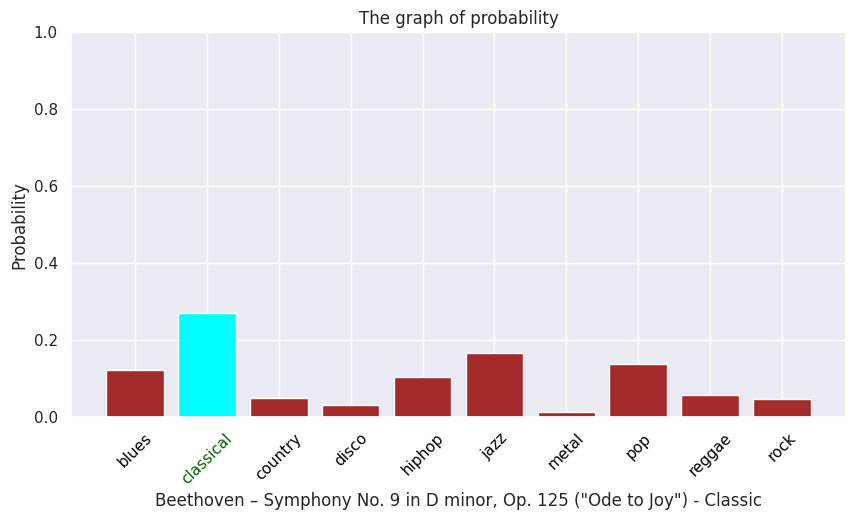

In [ ]:
y_prob1 = svm_cls.predict_proba(x)
i = 1
test = y_prob1[5]
category = label_encoder[i]
print(category)

# Xác định vị trí giá trị lớn nhất
print(test)
max_index = np.argmax(test)

# Tạo danh sách màu: giá trị lớn nhất là 'red', còn lại là 'skyblue'
colors = ['brown'] * len(test)
colors[max_index] = 'cyan'  # Làm nổi bật giá trị lớn nhất

# Vẽ biểu đồ với màu sắc tùy chỉnh
plt.figure(figsize=(10, 5))
plt.bar(label_encoder.values(), test, color=colors)

# Định dạng biểu đồ
#plt.xlabel(category.capitalize())
plt.xlabel('Beethoven – Symphony No. 9 in D minor, Op. 125 ("Ode to Joy") - Classic')
plt.ylabel("Probability")
plt.title("The graph of probability")
plt.ylim(0, 1)  # Xác suất nằm trong khoảng [0,1]

# Gán nhãn cho trục x bằng tên thể loại nhạc
# Use a range of numbers for ticks and label_encoder.values() for labels
# colors1 = ['black'] * len(test) # Removed this line as it's no longer needed
# colors1[y_test[i]] = 'green'  # Làm nổi bật giá trị lớn nhất # Removed this line as well

# Get the current x-axis ticks and labels
ticks = plt.xticks()[0]
labels = plt.xticks()[1]

# Loop through the ticks and labels, setting the color individually
for tick, label, color_val in zip(ticks, labels, ['black'] * len(test)):  # Initialize color_val here
    if label.get_text() == label_encoder[i]:  # Check if label matches the desired category
        color_val = 'darkgreen'
    label.set_color(color_val)

plt.xticks(ticks, labels, rotation=45)  # Set the ticks and labels with updated colors

# Hiển thị biểu đồ
plt.show()